# VAE + Clustering

- 元論文 VAE >> Auto-Encoding Variational Bayes https://arxiv.org/abs/1312.6114 (2013)

VAEによって潜在空間に射影して、それをクラスタリングすれば半教師なし（？）になる


## Import and Config

In [52]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
from sklearn.cluster import KMeans
from _main_base import *

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['akahara', 'madara'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = 10

# model
cfg.INPUT_HEIGHT = 28
cfg.INPUT_WIDTH = 28
cfg.INPUT_CHANNEL = 1
cfg.INPUT_MODE = None # None, RGB, GRAY, EDGE, CLASS_LABEL

cfg.OUTPUT_HEIGHT = 28
cfg.OUTPUT_WIDTH = 28
cfg.OUTPUT_CHANNEL = 1
cfg.OUTPUT_MODE = None  # RGB, GRAY, EDGE, CLASS_LABEL

cfg.OUTPUT_CMAP = 'gray' # matplotlib cmap  (default : None)

# AE config
cfg.VAE_Z_DIM = 2
cfg.AE_DIM = 32 # AE encodes feature to this
cfg.AE_STACK_NUM = 2 # AE stack number, e.g. Input > encoder 1 > encoder 2 > ... > encoder this
cfg.AE_DIM_EXPAND_BASE = 2 # AE : layer output = AE_DIM * (AE_DIM_EXPAND_BASE ** N (encoder or decoder stage))
cfg.VAE_KLD_BALANCE = 1 # loss = lossReconstruction + this * loss_KLD

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = False
cfg.DEVICE = torch.device('cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu')

# train
cfg.TRAIN = EasyDict()

cfg.PREFIX = 'VAE_mnist'
cfg.TRAIN.MODEL_E_SAVE_PATH = 'models/' + cfg.PREFIX + '_E_{}.pt' # save model to this path
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt' # save model to this path
cfg.TRAIN.MODEL_SAVE_INTERVAL = 10_000 # save model in each this
cfg.TRAIN.ITERATION = 10_000 # max training iteration
cfg.TRAIN.MINIBATCH = 512
cfg.TRAIN.OPTIMIZER = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS = {'lr' : 0.001, 'weight_decay' : 1e-5}
cfg.TRAIN.LOSS_FUNCTION = torch.nn.MSELoss(reduction='sum')

cfg.TRAIN.DATA_PATH = './data/' # use this dataset path
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = False # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = False # data augmentation : rotation False, or integer

cfg.TRAIN.DISPLAY_ITERATION_INTERVAL = 1000
cfg.TRAIN.LEARNING_PROCESS_PROGRESS_INTERVAL = 10 # save loss in each this
cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW = 1000 # integer , False (not show)
cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True # save result image and loss text
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 10_000 # save image and loss text in each this
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'


# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_E_PATH = cfg.TRAIN.MODEL_E_SAVE_PATH.format('final') # use this trained path
cfg.TEST.MODEL_D_PATH = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final') # use this trained path
cfg.TEST.DATA_PATH = './data' # use this dataset path
cfg.TEST.MINIBATCH = 10
cfg.TEST.MAX_SAMPLES = 30
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_E_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)


## Define Model

In [53]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class VAE_Encoder(torch.nn.Module):
    def __init__(self):
        super(VAE_Encoder, self).__init__()
        _layer_dim = max(cfg.AE_DIM * (cfg.AE_DIM_EXPAND_BASE ** (cfg.AE_STACK_NUM - 1)), cfg.AE_DIM)
        
        # Encoder
        module = OrderedDict({
            'encoder_flatten' : Flatten(),
            'encoder_1_layer' : torch.nn.Linear(cfg.INPUT_HEIGHT * cfg.INPUT_WIDTH * cfg.INPUT_CHANNEL, _layer_dim),
            'encoder_1_activation' : torch.nn.ReLU()
        })

        for i in range(2, cfg.AE_STACK_NUM + 1):
            module['encoder_{}_layer'.format(i)] = torch.nn.Linear(_layer_dim, _layer_dim // cfg.AE_DIM_EXPAND_BASE)
            module['encoder_{}_activation'.format(i)] = torch.nn.ReLU()      
            _layer_dim //= cfg.AE_DIM_EXPAND_BASE
            
        self.module = torch.nn.Sequential(module)
            
        self.encoder_mu = torch.nn.Linear(_layer_dim, cfg.VAE_Z_DIM)
        self.encoder_sigma = torch.nn.Linear(_layer_dim, cfg.VAE_Z_DIM)
        
        print('- encoder output : {} > {}'.format( _layer_dim, cfg.VAE_Z_DIM))
        
    def forward(self, x):
        x = self.module(x)
        mu = self.encoder_mu(x)
        sigma = self.encoder_sigma(x)
        return mu, sigma
    
    
class VAE_Sampler(torch.nn.Module):
    def __init__(self):
        super(VAE_Sampler, self).__init__()
        
    def forward(self, x):
        mu, sigma = x
        mb, _ = mu.size()
        epsilon = torch.tensor(np.random.normal(0, 1, [mb, cfg.VAE_Z_DIM]), dtype=torch.float32).to(cfg.DEVICE)
        std = torch.exp(0.5 * sigma)
        sample_z = mu + epsilon * std
        return sample_z
    
    
class VAE_Decoder(torch.nn.Module):
    def __init__(self):
        super(VAE_Decoder, self).__init__()
        _layer_dim = cfg.AE_DIM
        
        module = OrderedDict({
            'decoder_input' : torch.nn.Linear(cfg.VAE_Z_DIM, _layer_dim),
            'decoder_input_activation' : torch.nn.ReLU()
        })

        for i in range(cfg.AE_STACK_NUM, 1, -1):
            module['decoder_{}_layer'.format(i)] = torch.nn.Linear(_layer_dim, _layer_dim * cfg.AE_DIM_EXPAND_BASE)
            module['decoder_{}_activation'.format(i)] = torch.nn.ReLU()
            _layer_dim *= cfg.AE_DIM_EXPAND_BASE
            
        module['decoder_1'] = torch.nn.Linear(_layer_dim, cfg.OUTPUT_HEIGHT * cfg.OUTPUT_WIDTH * cfg.OUTPUT_CHANNEL)
        module['decoder_out_activation'] = torch.nn.Tanh()

        self.module = torch.nn.Sequential(module)
        
        
    def forward(self, x):
        x = self.module(x)
        #x = self.dec_out(x)
        #x = torch.sigmoid(x)
        return x

def loss_KLDivergence(mu, sigma):
    return - 0.5 * torch.sum(1 + sigma - torch.pow(mu, 2) - torch.exp(sigma))


## Utility

In [54]:
def result_show(model, Xs, path=None, save=False, show=False, figsize=(12, 4), cmap=None):
    _Xs = Xs.detach().cpu().numpy()
    _Xs = (_Xs * 127.5 + 127.5).astype(np.uint8)
    
    ys = model(Xs).detach().cpu().numpy()
    ys = (ys * 127.5 + 127.5).astype(np.uint8)
    ys = ys.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    
    if cfg.OUTPUT_CHANNEL == 1:
        _Xs = _Xs[:, 0]
        ys = ys[:, 0]
    else:
        _Xs = _Xs.transpose(0, 2, 3, 1)
        ys = ys.transpose(0, 2, 3, 1)

    show_max = min(cfg.TEST.MINIBATCH, len(ys))
        
    plt.figure(figsize=figsize)
    for i in range(show_max):
        # show input
        _X = _Xs[i]
        plt.subplot(2, show_max, i + 1)
        plt.imshow(_X, cmap=cmap)
        plt.axis('off')
        plt.title('Input{}'.format(i + 1))
        
        # show output
        _y = ys[i]
        plt.subplot(2, show_max, i + 1 + show_max)
        plt.imshow(_y, cmap=cmap)
        plt.axis('off')
        plt.title('Output{}'.format(i + 1))

    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()
    else:
        plt.close()

## Train

--------------------
VAE Encoder
- Input : 28 x 28 x 1
- encoder 1 : 784 > 64
- encoder 2 : 64 > 32
- encoder output : 32 > 2
--------------------
VAE Decoder
- Input : 2
- decoder 2 : 32 > 64
- decoder 1 : 64 > 784
- Output : (28 x 28 x 1)
--------------------
training data :  (60000, 28, 28)
training start
Iter:1000, Loss:79858.9219 (Recon:77146.6797, KLD:2712.2419)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

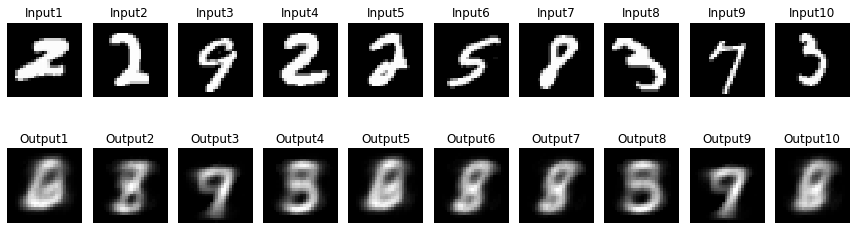

Iter:2000, Loss:77267.5000 (Recon:74409.9766, KLD:2857.5271)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

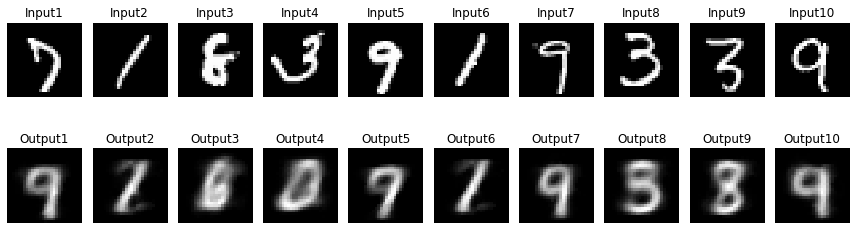

Iter:3000, Loss:72496.4375 (Recon:69488.1953, KLD:3008.2446)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

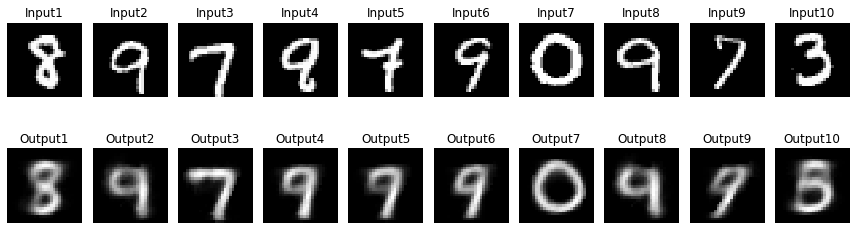

Iter:4000, Loss:71160.3828 (Recon:68036.3359, KLD:3124.0442)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

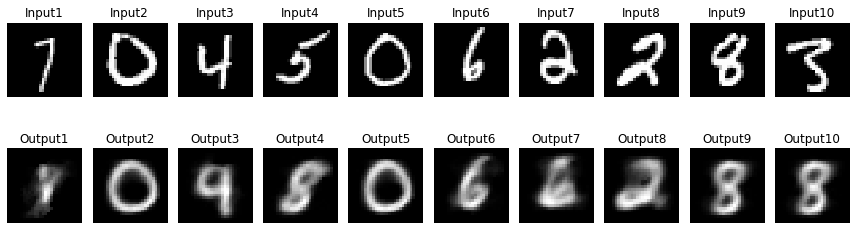

Iter:5000, Loss:70985.2969 (Recon:67770.7812, KLD:3214.5156)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

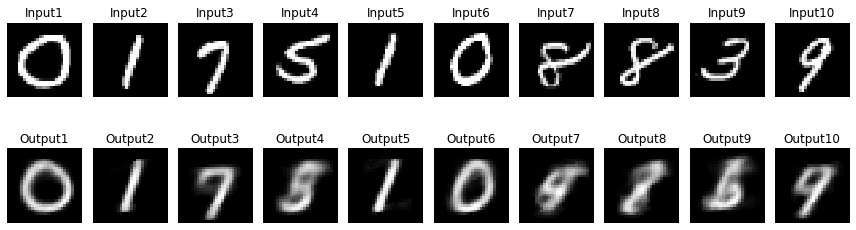

Iter:6000, Loss:71125.7969 (Recon:68004.9766, KLD:3120.8208)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

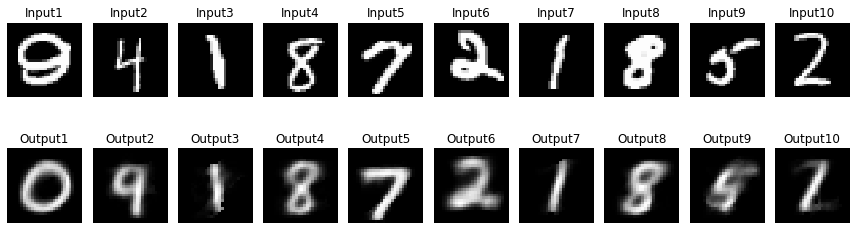

Iter:7000, Loss:68732.8828 (Recon:65447.2734, KLD:3285.6064)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

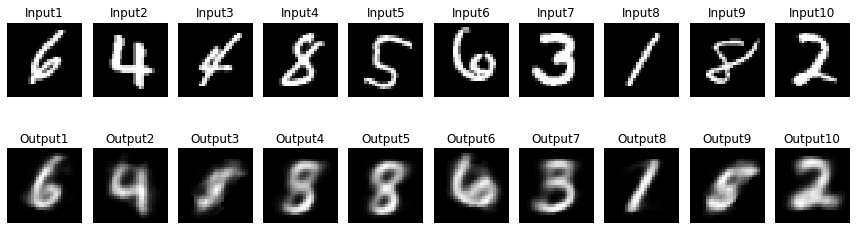

Iter:8000, Loss:68880.4297 (Recon:65697.3750, KLD:3183.0518)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

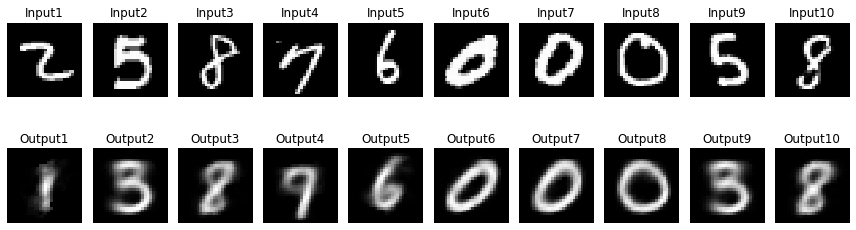

Iter:9000, Loss:69550.6328 (Recon:66231.6562, KLD:3318.9749)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

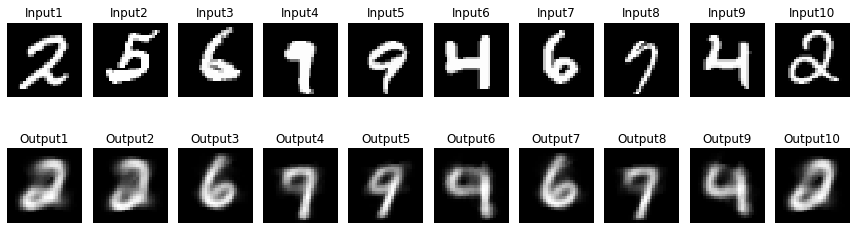

Iter:10000, Loss:69657.2578 (Recon:66346.4766, KLD:3310.7803)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

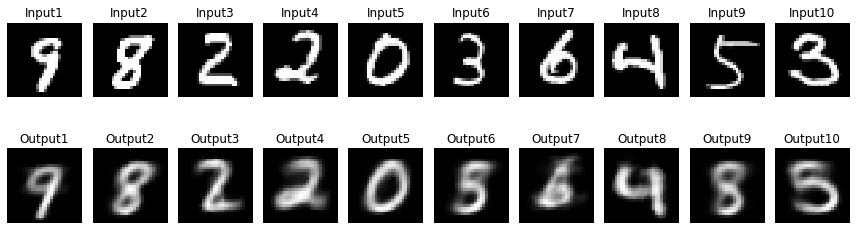

result was saved to >> result/VAE_mnist_result_iter10000.jpg
final paramters were saved toE >> models/VAE_mnist_E_final.pt, D >> models/VAE_mnist_D_final.pt
loss was saved to >> result/VAE_mnist_loss.txt


In [4]:
# train
def train():
    # model
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)
    model = torch.nn.Sequential(model_encoder, model_sampler, model_decoder)
    
    summary(model_encoder, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    summary(model_decoder, (cfg.VAE_Z_DIM, ))
    
    opt = cfg.TRAIN.OPTIMIZER(model.parameters(), **cfg.TRAIN.LEARNING_PARAMS)
    
    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']

    trainset = torchvision.datasets.MNIST(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    train_Xs = trainset.data.numpy()
    train_ts = trainset.targets
    
    print('training data : ', train_Xs.shape)

    # training
    mbi = 0
    train_N = len(train_Xs)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss = []
    list_loss_RECONSTRUCTION = []
    list_loss_KLD = []

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        # get minibatch
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        # train
        opt.zero_grad()

        # sample X, y
        Xs = torch.tensor(preprocess(train_Xs[mb_ind], cfg, cfg.INPUT_MODE, 
                                    hf=cfg.TRAIN.DATA_HORIZONTAL_FLIP, vf=cfg.TRAIN.DATA_VERTICAL_FLIP, rot=cfg.TRAIN.DATA_ROTATION),
                          dtype=torch.float).to(cfg.DEVICE)
        #ts = torch.tensor(train_ts[mb_ind], dtype=torch.float).to(device)

        # forward
        mu, sigma = model_encoder(Xs)
        z = model_sampler([mu, sigma])
        ys = model_decoder(z)
        
        # loss
        loss_recon = cfg.TRAIN.LOSS_FUNCTION(ys, Xs.view(cfg.TRAIN.MINIBATCH, -1))
        
        # loss KLDivergence
        loss_kld = loss_KLDivergence(mu, sigma)
        loss = loss_recon + cfg.VAE_KLD_BALANCE * loss_kld

        # update
        loss.backward()
        opt.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss = loss.item()
        _loss_recon = loss_recon.item()
        _loss_kld = loss_kld.item()

        if (i + 1) % cfg.TRAIN.LEARNING_PROCESS_PROGRESS_INTERVAL == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss.append(_loss)
                list_loss_RECONSTRUCTION.append(_loss_recon)
                list_loss_KLD.append(_loss_kld)
    
        # display training state
        if (i + 1) % cfg.TRAIN.DISPLAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, Loss:{:.4f} (Recon:{:.4f}, KLD:{:.4f})'.format(i + 1, _loss, _loss_recon, _loss_kld))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            save_path_E = cfg.TRAIN.MODEL_E_SAVE_PATH.format('iter{}'.format(i + 1))
            save_path_D = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(model_encoder.state_dict(), save_path_E)
            torch.save(model_decoder.state_dict(), save_path_D)
            print('save E >> {}, D >> {}'.format(save_path_E, save_path_D))

        # show process result
        if (cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW != False) and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW == 0):
            result_show(
                model, Xs, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=False, show=True, cmap=cfg.OUTPUT_CMAP)
            
        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                model, Xs, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=True, show=False, cmap=cfg.OUTPUT_CMAP)

    save_path_E = cfg.TRAIN.MODEL_E_SAVE_PATH.format('final')
    save_path_D = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(model_encoder.state_dict(), save_path_E)
    torch.save(model_decoder.state_dict(), save_path_D)
    print('final paramters were saved toE >> {}, D >> {}'.format(save_path_E, save_path_D))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss' : list_loss, 'loss_reconstruction' : list_loss_RECONSTRUCTION, 
                           'loss_KLD' : list_loss_KLD})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

- encoder output : 32 > 2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 64]          50,240
              ReLU-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
              ReLU-5                   [-1, 32]               0
            Linear-6                    [-1, 2]              66
            Linear-7                    [-1, 2]              66
Total params: 52,452
Trainable params: 52,452
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.20
Estimated Total Size (MB): 0.21
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (ty

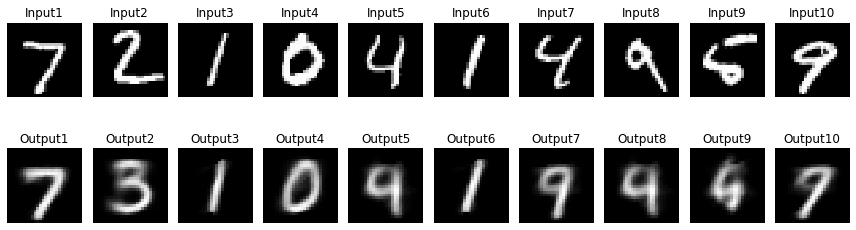

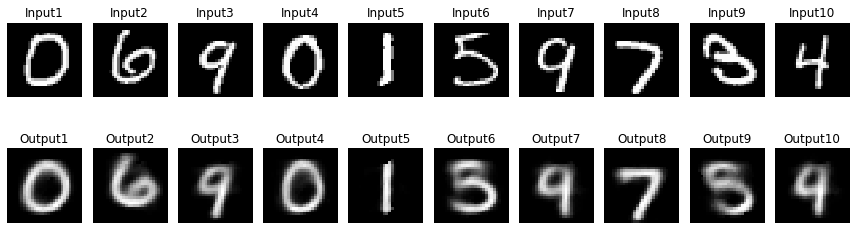

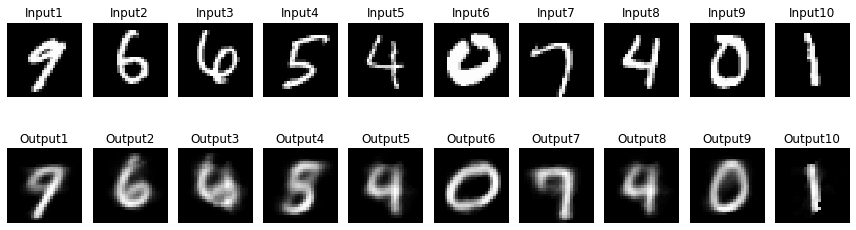

In [58]:
# test
def test():
    #print('-' * 20　+ '\ntest function\n' + '-' * 20)
    
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)
    model = torch.nn.Sequential(model_encoder, model_sampler, model_decoder)
    
    model_encoder.load_state_dict(torch.load(cfg.TEST.MODEL_E_PATH, map_location=torch.device(cfg.DEVICE)))
    model_decoder.load_state_dict(torch.load(cfg.TEST.MODEL_D_PATH, map_location=torch.device(cfg.DEVICE)))
    model.eval()
    
    summary(model_encoder, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    summary(model_decoder, (cfg.VAE_Z_DIM, ))

    #path_dict = data_load(cfg, train=False, hf=False, vf=False, rot=False)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']
    
    trainset = torchvision.datasets.MNIST(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    train_Xs = trainset.data.numpy()
    train_ts = trainset.targets
    
    Test_Num = min(len(train_Xs), cfg.TEST.MAX_SAMPLES)
    
    np.random.seed(0)
    
    with torch.no_grad():
        for i in range(0, Test_Num, cfg.TEST.MINIBATCH):
            mb_ind = np.arange(i, min(i + cfg.TEST.MINIBATCH, Test_Num))
            
            # sample X, y
            Xs = torch.tensor(preprocess(train_Xs[mb_ind], cfg, cfg.INPUT_MODE, hf=False, vf=False, rot=False), dtype=torch.float).to(cfg.DEVICE)           

            result_show(model, Xs, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), 
                        save=cfg.TEST.RESULT_SAVE, show=True, cmap=cfg.OUTPUT_CMAP)

test()

## Clustering

- encoder output : 32 > 2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 64]          50,240
              ReLU-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
              ReLU-5                   [-1, 32]               0
            Linear-6                    [-1, 2]              66
            Linear-7                    [-1, 2]              66
Total params: 52,452
Trainable params: 52,452
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.20
Estimated Total Size (MB): 0.21
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (ty

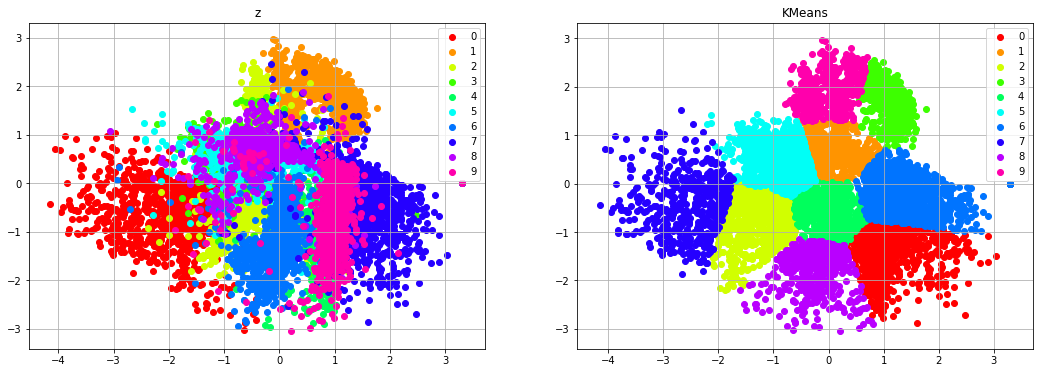

In [57]:
def latent_map():
    model_encoder = VAE_Encoder().to(cfg.DEVICE)
    model_sampler = VAE_Sampler().to(cfg.DEVICE)
    model_decoder = VAE_Decoder().to(cfg.DEVICE)

    model_encoder.load_state_dict(torch.load(cfg.TEST.MODEL_E_PATH, map_location=torch.device(cfg.DEVICE)))
    model_decoder.load_state_dict(torch.load(cfg.TEST.MODEL_D_PATH, map_location=torch.device(cfg.DEVICE)))
    model_encoder.eval()
    model_sampler.eval()
    model_decoder.eval()
    
    summary(model_encoder, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    summary(model_decoder, (cfg.VAE_Z_DIM, ))
    
    colors = np.array([matplotlib.cm.hsv(i / cfg.CLASS_NUM) for i in range(cfg.CLASS_NUM)])

    mb = 512
    
    testset = torchvision.datasets.MNIST(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    test_Xs = testset.data.numpy()
    test_ts = testset.targets
    
    z1_all = np.ndarray(shape=1)
    z2_all = np.ndarray(shape=1)
    ts = np.ndarray(shape=1)
    
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.title('z')
    
    with torch.no_grad():
        for class_i in range(cfg.CLASS_NUM):
            _test_Xs = test_Xs[test_ts == class_i]

            Test_Num = len(_test_Xs)
            
            z1 = np.ndarray(shape=1)
            z2 = np.ndarray(shape=1)
            
            for i in range(0, Test_Num, mb):
                mb_ind = np.arange(i, min(i + mb, Test_Num))

                # sample X, y
                Xs = torch.tensor(preprocess(_test_Xs[mb_ind], cfg, cfg.INPUT_MODE, hf=False, vf=False, rot=False), dtype=torch.float).to(cfg.DEVICE)           

                # forward
                mu, sigma = model_encoder(Xs)
                z = model_sampler([mu, sigma])
                
                z1 = np.append(z1, z[:, 0])
                z2 = np.append(z2, z[:, 1])

            plt.scatter(z1, z2, c=[colors[class_i]], label=class_i)
            
            z1_all = np.append(z1_all, z1)
            z2_all = np.append(z2_all, z2)
            ts = np.append(ts, [class_i] * len(z1))

    #---
    # KMeans
    #---
    clf = KMeans(n_clusters=cfg.CLASS_NUM, random_state=0)
    kmeans = clf.fit(np.array([z1_all, z2_all]).T)
    ys = kmeans.labels_
    
    plt.grid()
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('KMeans')
    
    for i in range(cfg.CLASS_NUM):
        _z1 = z1_all[ys == i]
        _z2 = z2_all[ys == i]
        plt.scatter(_z1, _z2, c=[colors[i]], label=i)
        
    # Accuracy is not valid, because class label is unknown
    """"
    diff = ts - ys
    diff[diff != 0] = 1
    correct = 1 - diff
    accuracy = correct.mean()
    
    print('Accuracy : {:.4f} ({} / {})'.format(accuracy, correct.sum(), correct.shape[0]))
    """

    plt.grid()
    plt.legend()
    #plt.savefig('result/vae_latent_show.png')
    plt.show()
    
latent_map()